In [ ]:
%pip install python-dotenv
%pip install langchain-pinecone langchain-openai langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.3/524.3 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
%pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 18.1 MB/s eta 0:00:00


In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("PINECONE_API_KEY")
_set_env("PINECONE_ENVIRONMENT")

OPENAI_API_KEY:··········
PINECONE_API_KEY:··········
PINECONE_ENVIRONMENT:··········


In [ ]:
%pip install langgraph_supervisor

In [ ]:
from dotenv import load_dotenv

load_dotenv()

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ReadTheDocsLoader
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
loader = ReadTheDocsLoader("https://www.edubull.com/Content/eRepository/SubjectContent/Notes/3634.pdf")
raw_documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=50)
documents = text_splitter.split_documents(raw_documents)
for doc in documents:
    new_url = doc.metadata["source"]
    doc.metadata.update({"source": new_url})
retriever = PineconeVectorStore.from_documents(
    documents, embeddings, index_name="project2"
).as_retriever()


In [ ]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    name="search_docs",
    description="Search the knowledge base."
)

In [ ]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI

response_model = ChatOpenAI(model="gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [ ]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "How was cricket spread in India?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_docs (call_EOVJ2YrwsuBWbp8xmFfHLe1o)
 Call ID: call_EOVJ2YrwsuBWbp8xmFfHLe1o
  Args:
    query: spread of cricket in India


In [ ]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_openai import ChatOpenAI

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "Instructions:\n"
    "- Return 'yes' if the document clearly answers the question.\n"
    "- If the document touches the topic or answers part of the question, return 'partially relevant'.\n"
    "- If the document does not answer the question at all, return 'no'.\n"
    "Return only one of these values exactly: 'yes', 'partially relevant', or 'no'. Do not include explanations."

)
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: Literal["yes", "partially relevant", "no"] = Field(
        description="Relevance score: 'yes' if clearly relevant, 'partially relevant' if loosely related, 'no' if unrelated"
    )
grader_model = ChatOpenAI(model="gpt-4o", temperature=0)

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question","ignore_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "should_generate_answer"
    elif score == "partially relevant":
        return "should_rewrite_question"
    else:
      return "should_ignore_question"

In [ ]:
from langchain_core.tools import tool

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from typing import List

IGNORE_PROMPT = (
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Here is the document:\n"
    "{context}\n\n"
    "If the document is not at all related to the question, respond with:\n"
    "'The question is not related to the document provided.'\n"
)
def ignore_question(state: MessagesState):
    """Ignore user question, if the document is not relevant at all."""
    # messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content
    prompt = IGNORE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from typing import List

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    # messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content
    prompt = REWRITE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [ ]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    # messages = state["messages"]
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [ ]:
from langchain_core.messages import AIMessage

def iterate_until_answerable(input_state, max_rewrites=3, verbose=True):
    state = input_state
    rewrite_attempts = 0
    rewrite_history = []

    while rewrite_attempts <= max_rewrites:
        result = grade_documents(state)

        if result == "generate_answer":
            if verbose:
                print(f"Suitable for answering after {rewrite_attempts} rewrite(s).")
            return generate_answer(state)

        elif result == "rewrite_question":
            if rewrite_attempts < max_rewrites:
                rewritten_dict = rewrite_question(state)["messages"][0]
                rewritten_msg = AIMessage(content=rewritten_dict["content"])
                state = {"messages": state["messages"] + [rewritten_msg]}
                rewrite_history.append(rewritten_msg.content)
                if verbose:
                    print(f"Rewrite {rewrite_attempts + 1}: {rewritten_msg.content}")
                rewrite_attempts += 1
            else:
                if verbose:
                    print("Max rewrites reached. Forcing an answer...")
                return generate_answer(state)

        else:
            if verbose:
                print("Question irrelevant to the document. Ignoring.")
            return ignore_question(state)

In [ ]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI

response_model = ChatOpenAI(model="gpt-4o", temperature=0)


supervisor = create_supervisor(
    model=response_model,
    agents=[ignore_question,rewrite_question,generate_answer],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a generate_answer agent. Returns answers for questions related to the document.\n"
        "- a ignore_question agent. Returns 'Not related' for questions completely irrelevant to the document.\n"
        "- an rewrite_question agent. Rewrites the question atmost 3 times before generating an answer to a question that is relevant to the document.\n"
        "INSTRUCTIONS:\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
workflow = StateGraph(MessagesState)
workflow.add_node(generate_query_or_respond)
workflow.add_node("supervisor", supervisor)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("ignore_question", ignore_question)
workflow.add_edge(START, "generate_query_or_respond")

workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",
    }
)
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    supervisor,
)

workflow.add_edge("retrieve", "supervisor")
workflow.add_edge("supervisor", "rewrite_question")
workflow.add_edge("supervisor", "generate_answer")
workflow.add_edge("supervisor", "ignore_question")
workflow.add_edge("rewrite_question","supervisor")
workflow.add_edge("generate_answer", "supervisor")
workflow.add_edge("ignore_question","supervisor")
workflow.add_edge("rewrite_question", "generate_query_or_respond")
workflow.add_edge("generate_answer", END)
workflow.add_edge("ignore_question", END)
workflow.add_edge("supervisor", END)
graph = workflow.compile()


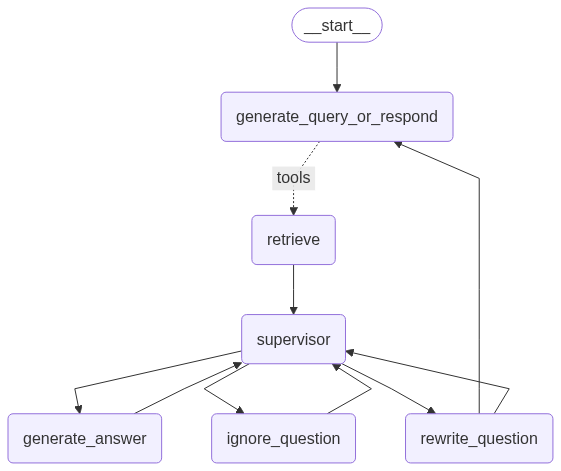

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import convert_to_messages

In [ ]:
from langgraph.graph import MessagesState

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How was cricket spread in India?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "How was cricket made popular?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "events that contributed to the spread of cricket in India?",
                "tool_call_id": "1",
            },
        ]
    )
}
answer=grade_documents(input)
print(answer)

if answer == "should_generate_answer":
    final_state = generate_answer(MessagesState(messages=input["messages"]))
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)
elif answer == "should_rewrite_question":
    final_state = rewrite_question(MessagesState(messages=input["messages"]))
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("New Question:", msg.content)
else:
    final_state = ignore_question(MessagesState(messages=input["messages"]))
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)

should_generate_answer


In [ ]:
for chunk in supervisor.stream(
    {
        "messages": [
            {"role": "user", "content": "events that contributed to the spread of cricket in India?"}
        ]
    }
):
    for node_name, update in chunk.items():
        print("Update from:", node_name)
        for msg in update.get("messages", []):
            print(msg.pretty_print() if hasattr(msg, "pretty_print") else msg)


Update from: supervisor
================================ Human Message =================================

events that contributed to the spread of cricket in India?
None
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_generate_answer (call_lqDZ8hKF3KfgFBfDOV1mVrH0)
 Call ID: call_lqDZ8hKF3KfgFBfDOV1mVrH0
  Args:
None
================================= Tool Message =================================
Name: transfer_to_generate_answer

Successfully transferred to generate_answer
None


ValidationError: 1 validation error for generate_answer
state
  Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 23}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How was cricket spread in India?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "How was cricket made popular?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "The origins of Indian cricket, that is, cricket played by Indians are to be found in Bombay.",
                "tool_call_id": "1",
            },
        ]
    )
}
answer=grade_documents(input)
print(answer)
if answer == "should_generate_answer":
    final_state = generate_answer.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)
elif answer == "should_rewrite_question":
    final_state = rewrite_question.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("New Question:", msg.content)
else:
    final_state = ignore_question.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)




should_rewrite_question


In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How was cricket spread in India?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "How was cricket made popular?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "distance between delhi and chennai",
                "tool_call_id": "1",
            },
        ]
    )
}
answer=grade_documents(input)
print(answer)
if answer == "should_generate_answer":
    final_state = generate_answer.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)
elif answer == "should_rewrite_question":
    final_state = rewrite_question.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("New Question:", msg.content)
else:
    final_state = ignore_question.invoke({"state": MessagesState(messages=input["messages"])})
    for msg in final_state["messages"]:
        if msg["role"] == "assistant":
            print("Final Answer:", msg.content)

should_ignore_question


In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "events that contributed to the spread of cricket in India?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  search_docs (call_oCgLGifLya0ESJGPfAVPXF0v)
 Call ID: call_oCgLGifLya0ESJGPfAVPXF0v
  Args:
    query: events that contributed to the spread of cricket in India





ValidationError: 1 validation error for generate_answer
state
  Field required [type=missing, input_value={'messages': [HumanMessag..., 'remaining_steps': 23}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing